In [6]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#import tensorflow as tf
#from tensorflow.keras import models, layers, optimizers, metrics
#from tensorflow.keras.layers.experimental.preprocessing import Normalization

In [2]:
from prophet import Prophet

In [7]:
path = "../raw_data/"

In [8]:
teste = os.path.join(path, "item_categories.csv")
teste

'../raw_data/item_categories.csv'

In [9]:
categories_ = pd.read_csv(os.path.join(path, "item_categories.csv"))
items_ = pd.read_csv(os.path.join(path, "items.csv"))
sales_ = pd.read_csv(os.path.join(path, "sales_train.csv"))
shops_ = pd.read_csv(os.path.join(path, "shops.csv"))
test_ = pd.read_csv(os.path.join(path, "test.csv"))
sample_ = pd.read_csv(os.path.join(path, "sample_submission.csv"))

In [14]:
categories_df = categories_.copy()
items_df = items_.copy()
shops_df = shops_.copy()
sales_df = sales_.copy()
test_df = test_.copy()
sample_df = sample_.copy()

In [15]:
sales_df["date"] = pd.to_datetime(sales_df.date, dayfirst=True)
sales_df = sales_df.merge(items_df[['item_id', 'item_category_id']], on='item_id')
sales_df['item_cnt_day'] = sales_df['item_cnt_day'].astype('int8')
sales_df['date_block_num'] = sales_df['date_block_num'].astype('int8')
sales_df['item_price'] = sales_df['item_price'].astype('float16')
sales_df.sort_values("date", inplace=True)

In [16]:
sales_df

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id
400417,2013-01-01,0,51,6622,347.00,1,30
130157,2013-01-01,0,7,1524,3000.00,1,29
867737,2013-01-01,0,19,18721,149.00,1,40
1004082,2013-01-01,0,54,15133,170.00,1,67
1004086,2013-01-01,0,41,15133,170.00,1,67
...,...,...,...,...,...,...,...
1788495,2015-10-31,33,58,3734,3400.00,1,23
2715396,2015-10-31,33,58,17748,288.25,1,70
1502745,2015-10-31,33,26,20949,5.00,3,71
2931438,2015-10-31,33,46,7223,4000.00,1,20


In [17]:
sales_df.dtypes

date                datetime64[ns]
date_block_num                int8
shop_id                      int64
item_id                      int64
item_price                 float16
item_cnt_day                  int8
item_category_id             int64
dtype: object

# Sorting the Data

## Group by Shop

### Sales Count per Week

In [18]:
shops_sales_per_week = pd.DataFrame()
shops_sales_per_week_dict = {}

for id in range(shops_df.shape[0]):
    shop_id = f"shop_id_{id}"
    df = sales_df[sales_df['shop_id'] == id].resample('W', on="date").sum()[["item_cnt_day"]]
    df.rename(columns = {'item_cnt_day':shop_id}, inplace=True)
    shops_sales_per_week_dict[shop_id] = df.shape[0]
    shops_sales_per_week = pd.concat([shops_sales_per_week, df], axis=1)

#shop_sales_month.fillna(0, inplace=True)
shops_sales_per_week

,shop_id_0,shop_id_1,shop_id_2,shop_id_3,shop_id_4,shop_id_5,shop_id_6,shop_id_7,shop_id_8,shop_id_9,...,shop_id_50,shop_id_51,shop_id_52,shop_id_53,shop_id_54,shop_id_55,shop_id_56,shop_id_57,shop_id_58,shop_id_59
date,,,,,,,,,,,,,,,,,,,,,
2013-01-06,1056.0,586.0,411,222,641,NaN,820,799,586.0,NaN,...,967,755.0,488,627,3126.0,NaN,1146,NaN,NaN,589
2013-01-13,1268.0,598.0,312,212,485,NaN,798,549,309.0,NaN,...,799,595.0,367,513,2157.0,NaN,780,NaN,NaN,411
2013-01-20,1305.0,678.0,281,124,458,NaN,830,469,264.0,NaN,...,667,546.0,401,400,1669.0,NaN,526,NaN,NaN,429
2013-01-27,1258.0,694.0,142,146,348,NaN,821,480,243.0,NaN,...,725,600.0,330,349,1762.0,NaN,547,NaN,NaN,432
2013-02-03,1436.0,817.0,0,175,426,NaN,833,448,252.0,NaN,...,599,533.0,374,423,1885.0,NaN,555,NaN,NaN,374
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-10-04,NaN,NaN,168,217,201,237.0,388,268,NaN,3187.0,...,200,14.0,195,258,NaN,854.0,281,456.0,336.0,148
2015-10-11,NaN,NaN,153,157,211,244.0,339,225,NaN,0.0,...,188,NaN,180,257,NaN,366.0,353,541.0,309.0,151
2015-10-18,NaN,NaN,178,146,186,257.0,487,323,NaN,-1.0,...,232,NaN,212,243,NaN,466.0,249,527.0,307.0,170


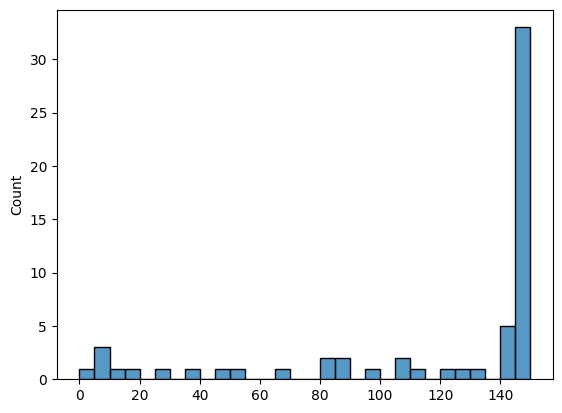

In [19]:
sns.histplot(shops_sales_per_week_dict, binwidth=5, binrange=(0, 148));

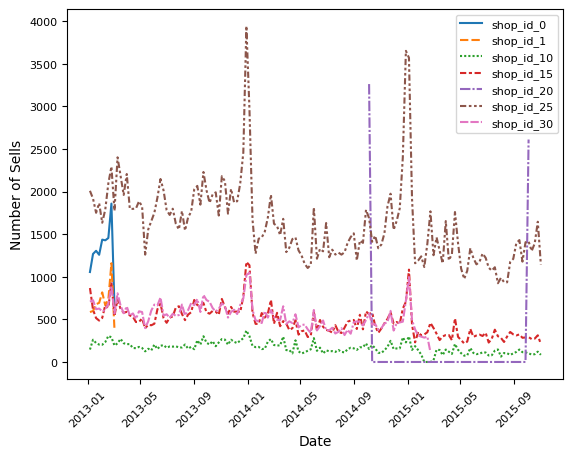

In [20]:
sns.lineplot(data=[
    shops_sales_per_week.shop_id_0,
    shops_sales_per_week.shop_id_1,
    shops_sales_per_week.shop_id_10,
    shops_sales_per_week.shop_id_15,
    shops_sales_per_week.shop_id_20,
    shops_sales_per_week.shop_id_25,
    shops_sales_per_week.shop_id_30
])
plt.xlabel("Date")
plt.ylabel("Number of Sells")
plt.tick_params(axis='x', labelsize=8, rotation=45)
plt.tick_params(axis='y', labelsize=8)
plt.legend(fontsize=8);

### Sales Values per Week

In [73]:
shops_values_per_week = pd.DataFrame()
shops_values_per_week_dict = {}

for id in range(shops_df.shape[0]):
    shop_id = f"shop_id_{id}"
    df = sales_df[sales_df['shop_id'] == id].resample('W', on="date").sum()[["item_price"]]
    df.rename(columns = {'item_price':shop_id}, inplace=True)
    shops_values_per_week_dict[shop_id] = df[[shop_id]].sum()[0]
    shops_values_per_week = pd.concat([shops_values_per_week, df], axis=1)

#shop_sales_month.fillna(0, inplace=True)
shops_values_per_week

,shop_id_0,shop_id_1,shop_id_2,shop_id_3,shop_id_4,shop_id_5,shop_id_6,shop_id_7,shop_id_8,shop_id_9,...,shop_id_50,shop_id_51,shop_id_52,shop_id_53,shop_id_54,shop_id_55,shop_id_56,shop_id_57,shop_id_58,shop_id_59
date,,,,,,,,,,,,,,,,,,,,,
2013-01-06,541141.0,306571.0,339015.5000,163664.50,394066.00000,NaN,538795.1250,519415.375,377135.0,NaN,...,701772.0625,262656.0,321967.1875,393540.0,1.753411e+06,NaN,631323.5000,NaN,NaN,471726.5625
2013-01-13,603629.0,267480.0,287780.8750,156213.00,331071.62500,NaN,617301.1875,406003.000,169523.0,NaN,...,594615.5000,234896.0,221581.0000,309680.0,1.245886e+06,NaN,509281.8125,NaN,NaN,318045.5000
2013-01-20,525870.0,319326.0,276500.8125,96326.50,293773.00000,NaN,552376.2500,300023.625,175855.0,NaN,...,605724.0000,150807.0,298933.5000,321255.5,9.543516e+05,NaN,286361.5000,NaN,NaN,352183.0000
2013-01-27,485367.0,288008.0,125619.5000,83605.00,205303.50000,NaN,515650.2500,337844.000,146889.5,NaN,...,543594.0000,179399.0,197321.5000,266209.5,8.723958e+05,NaN,305930.4375,NaN,NaN,246370.4375
2013-02-03,749832.0,386438.0,0.0000,137310.25,267520.50000,NaN,475438.7500,320157.750,130795.0,NaN,...,434565.0000,126742.0,191751.0000,254176.0,8.948352e+05,NaN,299002.1250,NaN,NaN,249678.6250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-10-04,NaN,NaN,255602.2500,237386.00,158169.25000,225973.500,407424.0000,373911.000,NaN,1249850.0,...,293483.0000,15839.0,306469.0000,347241.0,NaN,272515.0,281515.0000,395904.0,434161.96875,169202.0000
2015-10-11,NaN,NaN,225907.0000,154506.00,137015.90625,210525.625,358108.0000,229201.000,NaN,0.0,...,315684.5000,NaN,151875.0000,268835.0,NaN,218647.0,349021.0000,537966.0,357558.00000,142764.0000
2015-10-18,NaN,NaN,217150.0000,114717.50,123172.00000,248638.500,499052.5000,404496.875,NaN,3800.0,...,197641.0000,NaN,195599.5000,172841.0,NaN,276257.0,329935.0000,442278.0,370708.00000,166274.0000


In [52]:
df.sum()[0]

37267250.0

In [76]:
shops_values_per_week_dict.values()

dict_values([5553975.0, 2926224.0, 35107744.0, 26474972.0, 35337684.0, 33263270.0, 74563370.0, 56080896.0, 2226376.5, 4714484.0, 16442806.0, 479829.0, 49863616.0, 5333544.0, 36009508.0, 55601330.0, 48716320.0, 23523484.0, 62521240.0, 54305656.0, 2389383.5, 51483330.0, 42247604.0, 5023334.0, 56292330.0, 155568100.0, 48519864.0, 105656360.0, 125303790.0, 45291176.0, 38861320.0, 170773660.0, 5098869.0, 5594609.0, 7696178.5, 56827224.0, 356824.0, 37351270.0, 53607344.0, 15013779.0, 4080475.0, 38286176.0, 101558990.0, 42755044.0, 29421704.0, 33781304.0, 60938890.0, 62810480.0, 24300236.0, 18339764.0, 63361252.0, 21855486.0, 37651730.0, 47932140.0, 109676424.0, 21136346.0, 51699804.0, 91320620.0, 58467130.0, 37267250.0])

TypeError: 'NoneType' object is not iterable

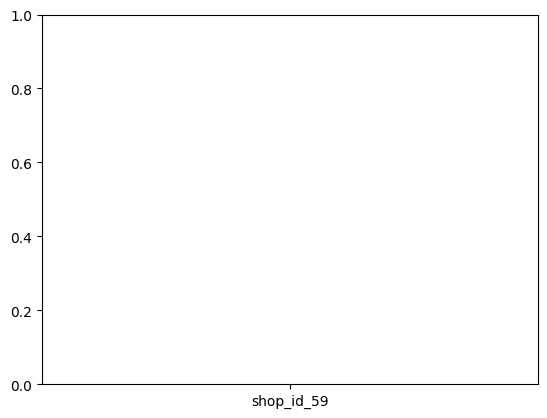

In [72]:
sns.lineplot(list(shops_values_per_week_dict.values()));

## Group by Category

### Sales Count per Week

In [21]:
cats_sales_per_week = pd.DataFrame()
cats_sales_per_week_dict = {}

for id in range(categories_df.shape[0]):
    cat_id = f"cat_id_{id}"
    df = sales_df[sales_df['item_category_id'] == id].resample('W', on="date").sum()[["item_cnt_day"]]
    df.rename(columns = {'item_cnt_day':cat_id}, inplace=True)
    cats_sales_per_week_dict[cat_id] = df.shape[0]
    cats_sales_per_week = pd.concat([cats_sales_per_week, df], axis=1)

#shop_sales_month.fillna(0, inplace=True)
cats_sales_per_week

,cat_id_0,cat_id_1,cat_id_2,cat_id_3,cat_id_4,cat_id_5,cat_id_6,cat_id_7,cat_id_8,cat_id_9,...,cat_id_74,cat_id_75,cat_id_76,cat_id_77,cat_id_78,cat_id_79,cat_id_80,cat_id_81,cat_id_82,cat_id_83
date,,,,,,,,,,,,,,,,,,,,,
2013-01-06,NaN,NaN,468,144,85.0,233,245,NaN,NaN,NaN,...,NaN,647,NaN,127,NaN,27,NaN,41.0,310.0,319
2013-01-13,1.0,1.0,303,93,30.0,150,206,NaN,NaN,21.0,...,NaN,712,NaN,122,NaN,21,NaN,38.0,325.0,201
2013-01-20,0.0,0.0,276,83,57.0,103,194,NaN,NaN,55.0,...,NaN,724,NaN,94,NaN,13,NaN,36.0,318.0,144
2013-01-27,0.0,0.0,241,87,56.0,99,156,NaN,NaN,34.0,...,NaN,588,NaN,87,NaN,56,NaN,43.0,289.0,164
2013-02-03,0.0,0.0,232,69,50.0,71,145,NaN,NaN,46.0,...,NaN,623,NaN,116,NaN,44,NaN,40.0,275.0,134
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-10-04,NaN,NaN,23,246,NaN,11,50,57.0,380.0,321.0,...,2.0,325,42.0,0,16.0,145,401.0,NaN,NaN,87
2015-10-11,NaN,NaN,21,239,NaN,8,64,40.0,0.0,81.0,...,1.0,171,40.0,5,10.0,136,NaN,NaN,NaN,73
2015-10-18,NaN,NaN,17,260,NaN,7,46,38.0,-1.0,96.0,...,1.0,169,45.0,3,21.0,119,NaN,NaN,NaN,81


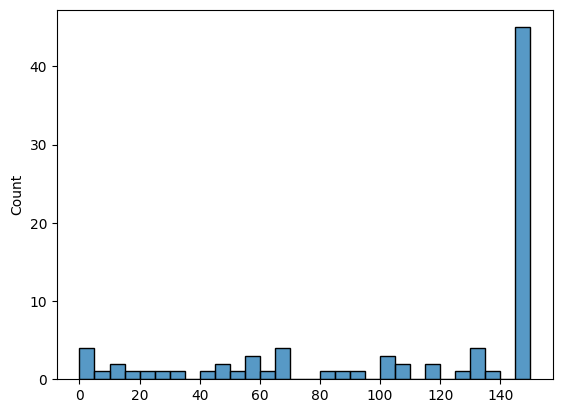

In [22]:
sns.histplot(cats_sales_per_week_dict, binwidth=5, binrange=(0, 148));

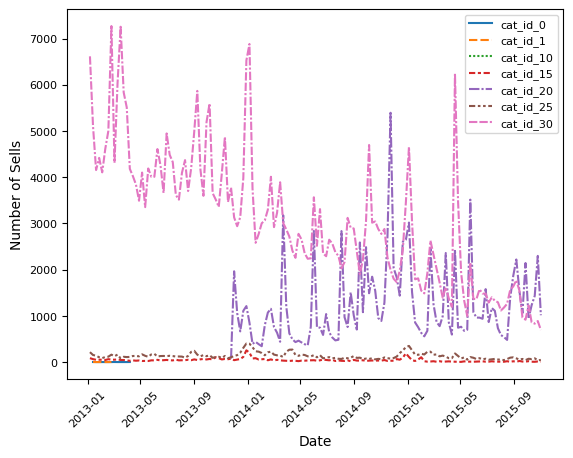

In [23]:
sns.lineplot(data=[
    cats_sales_per_week.cat_id_0,
    cats_sales_per_week.cat_id_1,
    cats_sales_per_week.cat_id_10,
    cats_sales_per_week.cat_id_15,
    cats_sales_per_week.cat_id_20,
    cats_sales_per_week.cat_id_25,
    cats_sales_per_week.cat_id_30
])
plt.xlabel("Date")
plt.ylabel("Number of Sells")
plt.tick_params(axis='x', labelsize=8, rotation=45)
plt.tick_params(axis='y', labelsize=8)
plt.legend(fontsize=8);

# Data

In [ ]:
sales_df.sample(10)

In [ ]:
sales_df.describe()

In [ ]:
sales_df.item_cnt_day.nunique()

In [ ]:
open_shops = np.sort(test_df['shop_id'].unique())
open_shops

In [ ]:
test_df.nunique()

In [ ]:
print("Categories:", categories_df.shape)
print("Items:", items_df.shape)
print("Shops:", shops_df.shape)
print("Sales:", sales_df.shape)
print("Test:", test_df.shape)
print("Sample:", sample_df.shape)

In [ ]:
# Total shop * itens, diff with sample
total = items_df.shape[0] * shops_df.shape[0]
print("Total shop * itens:", total)
print("Diffrence with the smple:", total - sample_df.shape[0])

In [ ]:
sales_df.dtypes

In [ ]:
sales_df

In [ ]:
shops_sales_month = pd.pivot_table(
    sales_df, values='item_cnt_day',
    index=['shop_id', 'item_id'], columns=['date_block_num'],
    aggfunc=np.sum 
)
shops_sales_month.fillna(0, inplace=True)
shops_sales_month.reset_index(inplace=True)

In [ ]:
shops_sales_month

In [ ]:
shops_sales_month['final_id'] = shops_sales_month['shop_id'].astype(str) + "-" + shops_sales_month['item_id'].astype(str)
shops_sales_month.set_index('final_id', inplace=True)
shops_sales_month.drop(columns=['shop_id', 'item_id'], inplace=True)
shops_sales_month = shops_sales_month.T

In [ ]:
shops_sales_month

In [ ]:
plot_cols = ['0-32', '0-49', '59-22144', '59-22167']
plot_features = shops_sales_month[plot_cols]
plot_features.index = shops_sales_month.index
plot_features.plot(subplots = True);

## Model

In [ ]:
def get_Xi_yi(
    fold:pd.DataFrame, 
    input_length:int, 
    output_length:int):
    '''
    - given a fold, it returns one sequence (X_i, y_i)
    - with the starting point of the sequence being chosen at random
    '''
    # $CHALLENGIFY_BEGIN
    first_possible_start = 0
    last_possible_start = len(fold) - (input_length + output_length) + 1
    random_start = np.random.randint(first_possible_start, last_possible_start)
    X_i = fold.iloc[random_start:random_start+input_length]    
    y_i = fold.iloc[random_start+input_length:
                  random_start+input_length+output_length][[TARGET]]
    
    return (X_i, y_i)
    # $CHALLENGIFY_END

In [ ]:
TARGET = '0-32'

In [ ]:
X_train, y_train = get_Xi_yi(shops_sales_month, 10, 10)

In [ ]:
X_train

In [ ]:
y_train

In [ ]:
def init_model(X_train, y_train):
    
    model = models.Sequential()
    model.add(layers.LSTM(64, 
                          activation='tanh', 
                          return_sequences = False,
                          recurrent_dropout = 0.3))
    ## 1.2 - Predictive Dense Layers
    output_length = y_train.shape[1]
    model.add(layers.Dense(output_length, activation='linear'))

    # 2 - Compiler
    # ======================    
    adam = optimizers.Adam(learning_rate=0.02)    
    model.compile(loss='mse', optimizer=adam, metrics=["mae"])
    
    return model

In [ ]:
init_model(X_train, y_train)

# old

In [ ]:
sales_df[sales_df['shop_id'] == 10].sort_values("date").groupby(by='date').sum('item_cnt_day')

In [ ]:
shop_sales_month =pd.DataFrame({"date_block_num": range(34)})
type(shop_sales_month)

In [ ]:
total_month_dict = {}
for id in range(shops_df.shape[0]):
    shop_id = f"shop_id_{id}"
    df = sales_df[sales_df['shop_id'] == id].groupby(by='date_block_num').sum('item_cnt_day')
    total_month_dict[shop_id] = df.shape[0]
    shop_sales_month[shop_id] = df.item_cnt_day
shop_sales_month.fillna(0, inplace=True)
shop_sales_month.drop(columns=['date_block_num'], inplace=True)

In [ ]:
shop_sales_month

In [ ]:
closed_shops = shop_sales_month.iloc[31:34]
closed_shops = pd.DataFrame(shop_sales_month.iloc[31:34].sum()).T
closed_shops

In [ ]:
pd.DataFrame(shop_sales_month.iloc[31:34].sum()).head(60)

In [ ]:
plt.plot(shop_sales_month.shop_id_0)
plt.plot(shop_sales_month.shop_id_1)
plt.plot(shop_sales_month.shop_id_8)
plt.plot(shop_sales_month.shop_id_9)

plt.plot(shop_sales_month.shop_id_11)
plt.plot(shop_sales_month.shop_id_13)
plt.plot(shop_sales_month.shop_id_17)
plt.plot(shop_sales_month.shop_id_20)
plt.plot(shop_sales_month.shop_id_23)
plt.plot(shop_sales_month.shop_id_27)

plt.plot(shop_sales_month.shop_id_29)
plt.plot(shop_sales_month.shop_id_30)
plt.plot(shop_sales_month.shop_id_32)
plt.plot(shop_sales_month.shop_id_33)
plt.plot(shop_sales_month.shop_id_40)
plt.plot(shop_sales_month.shop_id_27)


plt.plot(shop_sales_month.shop_id_43)
plt.plot(shop_sales_month.shop_id_51)
plt.plot(shop_sales_month.shop_id_54)
plt.plot(range(34))

In [ ]:
plt.plot(shop_sales_month.shop_id_27)
#plt.plot(shop_sales_month.shop_id_41)
#plt.plot(shop_sales_month.shop_id_42)
#plt.plot(shop_sales_month.shop_id_43)
#plt.plot(shop_sales_month.shop_id_44)
#plt.plot(shop_sales_month.shop_id_45)
#plt.plot(shop_sales_month.shop_id_46)

In [ ]:
sns.displot(total_month_dict, bins=34)
plt.xlim(1, 35, )

In [ ]:
total_month_dict

In [ ]:
open_shops